5-9. 회귀 실습 - 자전거 대여 수요 예측

1.데이터 클렌징 및 가공

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

bike_df=pd.read_csv('/Users/bluecloud/Documents/대학/유런/데이터셋/bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
# datetime 칼럼만 object형식  >> 문자열을 년도, 월, 일, 시간, 분, 초로 변환하기 위해'datetime' 타입으로 변경
bike_df['datetime']=bike_df.datetime.apply(pd.to_datetime)

#datetime 타입에서 년월일시간 추출
bike_df['year']=bike_df.datetime.apply(lambda x:x.year)
bike_df['month']=bike_df.datetime.apply(lambda x:x.month)
bike_df['day']=bike_df.datetime.apply(lambda x:x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x:x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [7]:
# 기존 datetime 칼럼 삭제
# 상관도가 높은 registered, casual 칼럼 삭제(등록x와 등록, 둘이 합치면 count)
drop_columns=['datetime','registered','casual']
bike_df.drop(drop_columns,axis=1,inplace=True)

*오버플로우 오류 발생때문에 log()& mean_squared_error()보다는 log1p()으로

In [11]:
#회귀 모델 적용하여 성능 평가 해보기 > RMSLE,MSE, RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 변환 값 변환 시 NaN 등의 이슈로 log()가 이닌 log1p()로 RMSLE 계산
def rmsle(y,pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y-log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle

#사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

#RMSLE,MSE,RMSE 계산
def evaluate_regr(y,pred):
    rmsle_val=rmsle(y,pred)
    rmse_val=rmse(y,pred)
    mae_val=mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val,rmse_val,mae_val))

2. 로그 변환, 피처 인코딩과 모델 학습/예측/평가
   - 결괏값이 정규 분포로 돼 있는지
   - 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처 인코딩

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso

y_target=bike_df['count']
X_features=bike_df.drop(['count'],axis=1,inplace=False)
X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.3,random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred=lr_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [15]:
#df의 칼럼으로 실제 대여 횟수와 예측값을 서로 비교할 수 있도록 생성
def get_top_error_data(y_test,pred,n_tops=5):
    result_df=pd.DataFrame(y_test.values,columns=['real_count'])
    result_df['predicted_count']=np.round(pred)
    result_df['diff']=np.abs(result_df['real_count']-result_df['predicted_count'])
    # 예측값과 실제 값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff',ascending=False)[:n_tops])

get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

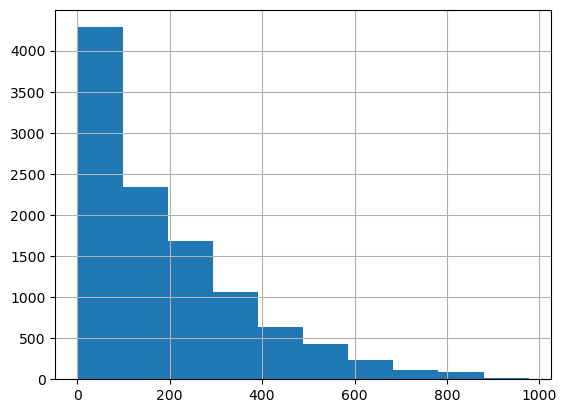

In [17]:
#if 왜곡, 예측 성능 저하됨 > target값이 정규 분포를 이루고 있는지 확인
y_target.hist()

>> 정규 분포가 아닌 0~200 사이에 왜곡됨 >> log1p()변환 사용

<Axes: >

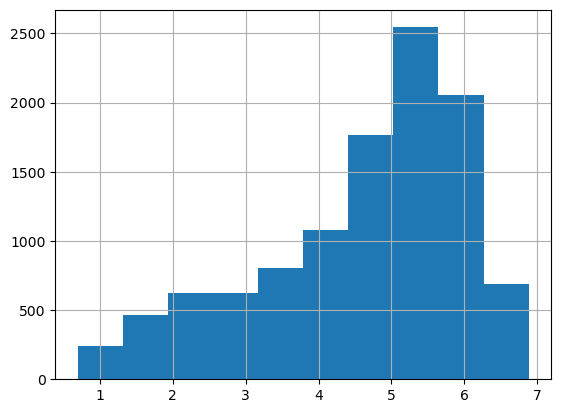

In [21]:
y_log_transform=np.log1p(y_target)
y_log_transform.hist()

In [25]:
# 로그로 target 값 변환 후(왜곡 정도가 향상) 학습한 후 평가

# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log=np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train,X_test,y_train,y_test=train_test_split(X_features,y_target_log,test_size=0.3,random_state=0)
lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred=lr_reg.predict(X_test)

# 테스트 데이터 세트의 타깃값은 로그 변환됐으므로 expm1으로 원래 스케일 변환
y_test_exp=np.expm1(y_test)

# 예측값 역시 다시 expm1으로 원래 스케일 변환
pred_exp=np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


>> RMSLE 오류는 줄어들었지만, RMSE는 늘어남

<Axes: ylabel='None'>

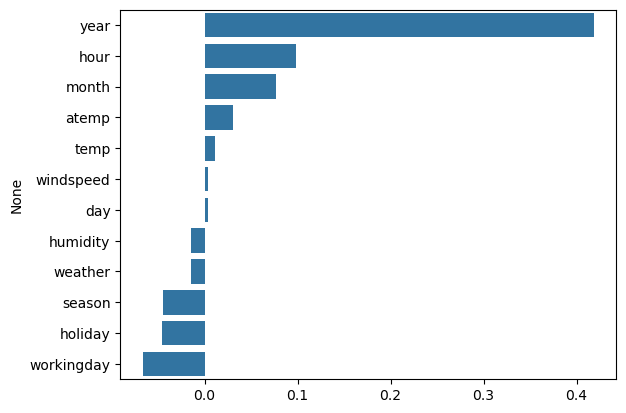

In [27]:
coef=pd.Series(lr_reg.coef_,index=X_features.columns)
coef_sort=coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values,y=coef_sort.index)

>> year의 회귀 계수 값이 독보적으로 큼 >> 2011,2012년 두 개의 값인데 대여 횟수에 크게 영향...을 줄리가
>> 연도는 카테고리만을 위한 데이터 타입으로... 원-핫 인코딩


In [29]:
# 연도, 월, 일, 시간을 원 핫 인코딩
X_features_ohe=pd.get_dummies(X_features,columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])


In [33]:
# 원-핫 인코딩이 적용된 데이터 세트 기반으로 학습/예측 데이터 분할
X_train,X_test,y_train,y_test=train_test_split(X_features_ohe,y_target_log,test_size=0.3,random_state=0)

# 성능 수치를 반환하는 get_model_predict()함수를 만들기
def get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=False):
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    if is_expm1:
        y_test=np.expm1(y_test)
        pred=np.expm1(pred)
    print("###",model.__class__.__name__,"###")
    evaluate_regr(y_test,pred)

# 모델별로 평가 수행
lr_reg=LinearRegression()
ridge_reg=Ridge(alpha=10)
lasso_reg=Lasso(alpha=0.01)

for model in [lr_reg,ridge_reg,lasso_reg]:
    get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.689, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<Axes: ylabel='None'>

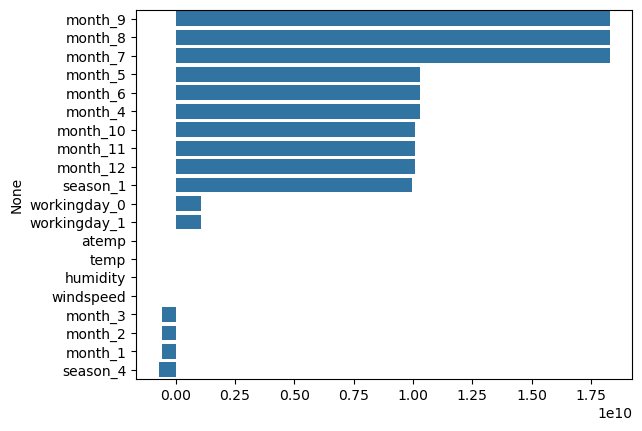

In [35]:
# 회귀 계수 상위 25개 피처 추출
coef=pd.Series(lr_reg.coef_,index=X_features_ohe.columns)
coef_sort=coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values,y=coef_sort.index)

>> 월과 관련 피처들과 workingday 관련 피처, hour 관련 피처들의 회귀 계수가 높다
>> 피처의 인코딩이 성능에 큰 영향을 미친다..!

In [37]:
# 회귀 트리로, 로그 변환과 원-핫 인코딩된 데이터 세트를 그대로 이용
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 각 모델별로 평가 수행
rf_reg=RandomForestRegressor(n_estimators=500)
gbm_reg=GradientBoostingRegressor(n_estimators=500)
xgb_reg=XGBRegressor(n_estimators=500)
lgbm_reg=LGBMRegressor(n_estimators=500)

for model in [rf_reg,gbm_reg,xgb_reg,lgbm_reg]:
    get_model_predict(model,X_train.values,X_test.values,y_train.values,y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.374, MAE: 31.142
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.334, MAE: 32.746
### XGBRegressor ###
RMSLE: 0.339, RMSE: 51.475, MAE: 31.357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


5-10. 회귀 실습 - 캐글 주택 가격 : 고급 회귀 기법
- 성능평가는 오류값을 로그 변환한 RMSLE를 기반으로

1. 데이터 사전 처리

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

house_df_org=pd.read_csv('/Users/bluecloud/Documents/대학/유런/데이터셋/house_price.csv')
house_df=house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [45]:
# target값은 SalePrice, Null이 있는 칼럼과 건수를 내림차순으로 출력
print('데이터 세트의 Shape :',house_df.shape)
print('\n전체 피처의 type\n :',house_df.dtypes.value_counts())
isnull_series=house_df.isnull().sum()
print('\nNull 칼럼과 그 건수 : \n',isnull_series[isnull_series>0].sort_values(ascending=False))

데이터 세트의 Shape : (1460, 81)

전체 피처의 type
 : object     43
int64      35
float64     3
Name: count, dtype: int64

Null 칼럼과 그 건수 : 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


>> target 제외한 80개의 피처중 43개가 문자형
>> Null 값이 많은 피처는 drop

<Axes: title={'center': 'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

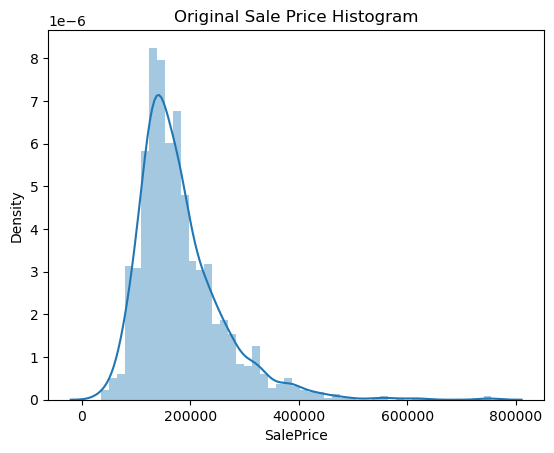

In [49]:
# 타깃값의 분포도가 정규분포인지 확인
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

<Axes: title={'center': 'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

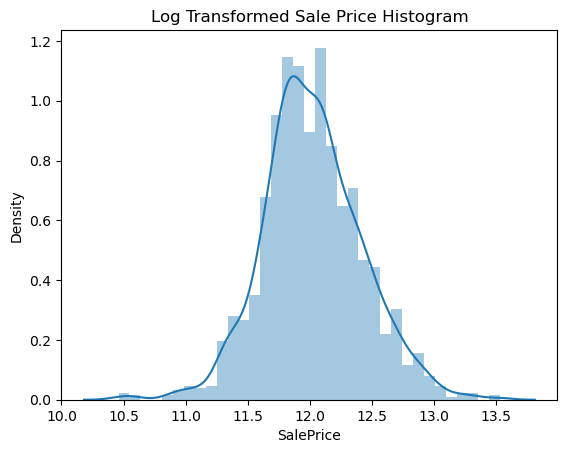

In [51]:
# 정규 분포 형태로 변환하기 위해 log1p()로 고르 변환, 결괏값은 expm1으로 환원
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice=np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [55]:
# SalePrice 로그 변환
original_SalePrice=house_df['SalePrice']
house_df['SalePrice']=np.log1p(house_df['SalePrice'])

#Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis = 1 , inplace = True)

#드롭하지 않은 숫자형 Null 칼럼은 평균값으로
house_df.fillna(house_df.mean(numeric_only=True),inplace=True)

#Null 값이 있는 피처명과 타입을 추출
null_column_count=house_df.isnull().sum()[house_df.isnull().sum()>0]
print("## Null 피처의 type :\n",house_df.dtypes[null_column_count.index])

## Null 피처의 type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [59]:
#get_dummies로 원핫 인코딩 변환하기
print('get_dummies() 수행 전 데이터 shape :',house_df.shape)
house_df_ohe=pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape :',house_df_ohe.shape)

#Null 값이 있는 피처명과 타입을 추출
null_column_count=house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print("## Null 피처의 type :\n",house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 shape : (1460, 75)
get_dummies() 수행 후 데이터 shape : (1460, 270)
## Null 피처의 type :
 Series([], dtype: object)


2. 선형 회귀 모델 학습/예측/평가
- 예측값 >> 이미 로그 변환된 SalePrice 값을 기반으로 예측
>> 예측 결과 오류에 RMSE만 적용하면 RMSLE는 자동으로 측정

In [61]:
def get_rmse(model):
    pred = model.predict(x_test)
    mse  = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__,' 로그 변환된 RMSE:', np.round(rmse,3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [86]:
# 선형 회귀 모델을 학습예측평가 ㄱ
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

y_target = house_df_ohe['SalePrice']
x_data = house_df_ohe.drop('SalePrice', axis = 1, inplace = False)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_target, test_size = 0.3, random_state = 1)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg=LinearRegression()
lr_reg.fit(x_train, y_train)
lasso_reg= Lasso()
lasso_reg.fit(x_train, y_train)
ridge_reg= Ridge()
ridge_reg.fit(x_train, y_train)

models=[lr_reg,ridge_reg,lasso_reg]
get_rmses(models)

LinearRegression  로그 변환된 RMSE: 0.138
Ridge  로그 변환된 RMSE: 0.141
Lasso  로그 변환된 RMSE: 0.199


[0.13820313916742563, 0.1411103820313566, 0.1985573211729677]

>> 라쏘 회귀는 성능이 떨어져보임 >> 최적화 하이퍼 파라미터(alpha) 튜닝 필요

ValueError: Length of values (269) does not match length of index (12)

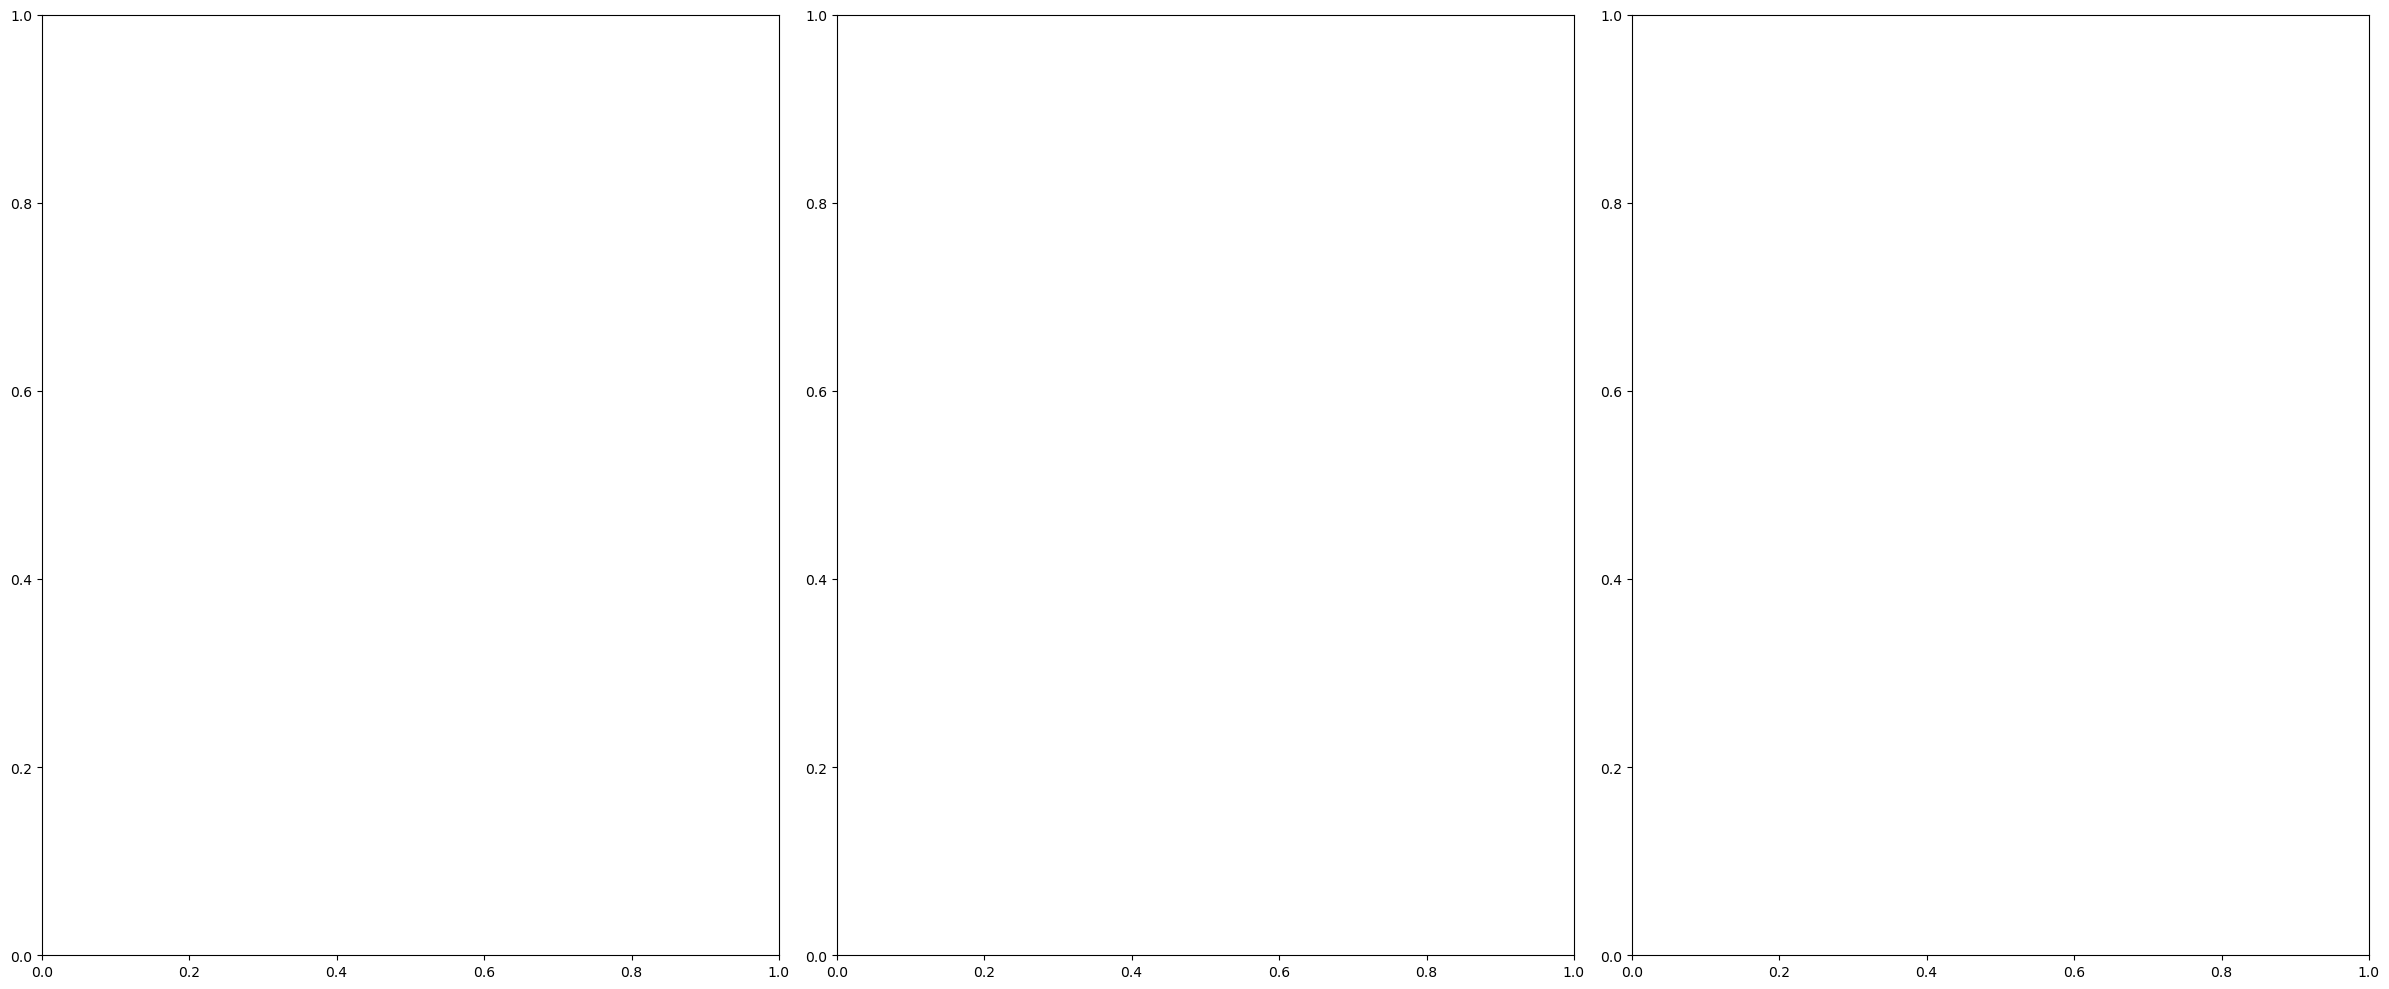

In [88]:
# 먼저 피처별 회귀 계수를 시각화, 모델별로 어떠한 회귀 계수로 구성되었는지 확인
def get_top_bottom_coef(model,n=10):
    #coef_ 속성을 기반으로 Series 객체 생성, index는 칼럼명
    coef=pd.Series(model.coef_,index=X_features.columns)

    #상하위 10개의 회귀 계수를 추출해 반환
    coef_high=coef.sort_values(ascending=False).head(n)
    coef_low=coef.sort_values(ascending=False).tail(n)
    return coef_high,coef_low

# 시각화 함수 
def visualize_coefficient(models):
    # 3개의 회귀 모델을 위해 3개의 칼럼을 갖는 subplot
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()
    # 입력인자로 받은 models에서 차례로 적용해서 회귀 계수 시각화
    for i_num, model in enumerate(models):
        # 상하위 10개를 회귀 계수 구하고 판다스 concat으로 결합
        coef_high,coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high,coef_low])
        # 조절
        axs[i_num].set_title(model.__class__.__name__+'Coefficients', size = 25)
        axs[i_num].tick_params(axis="y", direction="in", pad =-120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# 시각화 
models=[lr_reg,lasso_reg,ridge_reg]
visualize_coefficient(models)

In [90]:
#분활하지 않고 5개의 교차 검증 폴드 세트로 분할해 평균 RmSE 측정
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring = "neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{} CV RMSE 값 리스트: {}'.format(model.__class__.__name__,np.round(rmse_list,3)))
        print('\n{} CV 평균 RMSE 값 : {}'.format(model.__class__.__name__,np.round(rmse_avg,3)))
        
models=[lr_reg,lasso_reg,ridge_reg]
get_avg_rmse_cv(models)

ValueError: Found input variables with inconsistent numbers of samples: [10886, 1460]

In [96]:
# 최적의 하이퍼 파라미터 값 출력
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid = params, scoring = "neg_mean_squared_error", cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값 : {1}, 최적 alpha : {2}'.format(model.__class__.__name__,np.round(rmse,4),grid_model.best_params_))
ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)  

ValueError: Found input variables with inconsistent numbers of samples: [10886, 1460]

In [98]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg= Ridge(alpha = 12)
ridge_reg.fit(X_train, y_train)
lasso_reg= Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 RMSE 출력
models = [lr_reg,ridge_reg,lasso_reg]
get_rmses(models)

#모든 모델의 회귀 계수 시각화
models = [lr_reg,ridge_reg,lasso_reg]
visualize_coefficient(models)

ValueError: Found input variables with inconsistent numbers of samples: [7620, 1022]

In [100]:
from scipy.stats import skew

# 숫자형 칼럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 입력하면 해당 칼럼 데이터 세트 반환
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew 왜곡 정도가 1이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending = False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [102]:
# 높은 피처를 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [104]:
# 원핫 인코딩 적용하고 피처/타킷 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis = 1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(X_features , y_target, test_size = 0.2, random_state = 156)

# 피처를 로그 변환한 후 최적 하이퍼 파라미터와 RMSE 출력

ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}

print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1275, 최적 alpha : {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1252, 최적 alpha : {'alpha': 0.001}


Text(0.5, 0, 'GrLivArea')

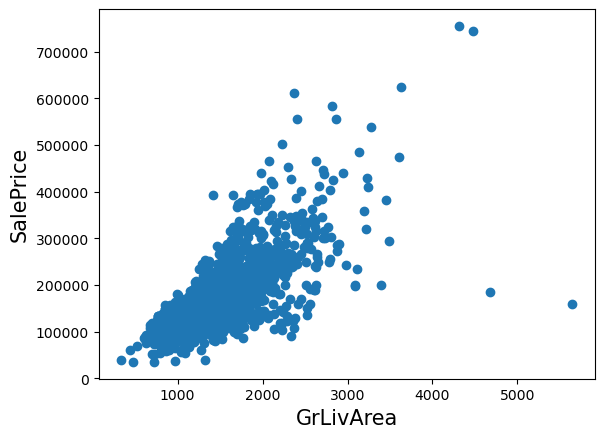

In [106]:
# 이상치 데이터 분포 살펴보기
plt.scatter(x=house_df_org['GrLivArea'],y=house_df_org['SalePrice'])
plt.ylabel('SalePrice',fontsize=15)
plt.xlabel('GrLivArea',fontsize=15)

In [110]:
# 4000평방피트 이상임에도 가격이 500,000달로 이하 데이터는 이상치로 간주

# 로그변환되었으므로 이를 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] <= np.log1p(500000)
outlier_index= house_df_ohe[cond1&cond2].index
print('이상치 레코드 index :',outlier_index.values)
print('이상치 삭제 전 house_df_oh shape :',house_df_ohe.shape)

# 이상치 레코드 삭제
house_df_ohe.drop(drop_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_oh shape :',house_df_ohe.shape)

이상치 레코드 index : [ 523 1298]
이상치 삭제 전 house_df_oh shape : (1460, 270)
이상치 삭제 후 house_df_oh shape : (1458, 270)


In [112]:
# 릿지와 라쏘 모델 최적화 수행
#이상치가 제거된 데이터를 통해서 다시 데이터 분할

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1125, 최적 alpha : {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1122, 최적 alpha : {'alpha': 0.001}


3. 회귀 트리 모델 학예평

In [114]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1181, 최적 alpha : {'n_estimators': 1000}


In [116]:
# lightgbm 회귀 트리 적용
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 171
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3167
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 168
[LightGBM] [Info] Start training from score 12.023516
[LightGBM] [Warning] Found

XGBRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1181, 최적 alpha : {'n_estimators': 1000}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 171
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3167
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 168
[Li

AttributeError: 'NoneType' object has no attribute 'feature_importances_'

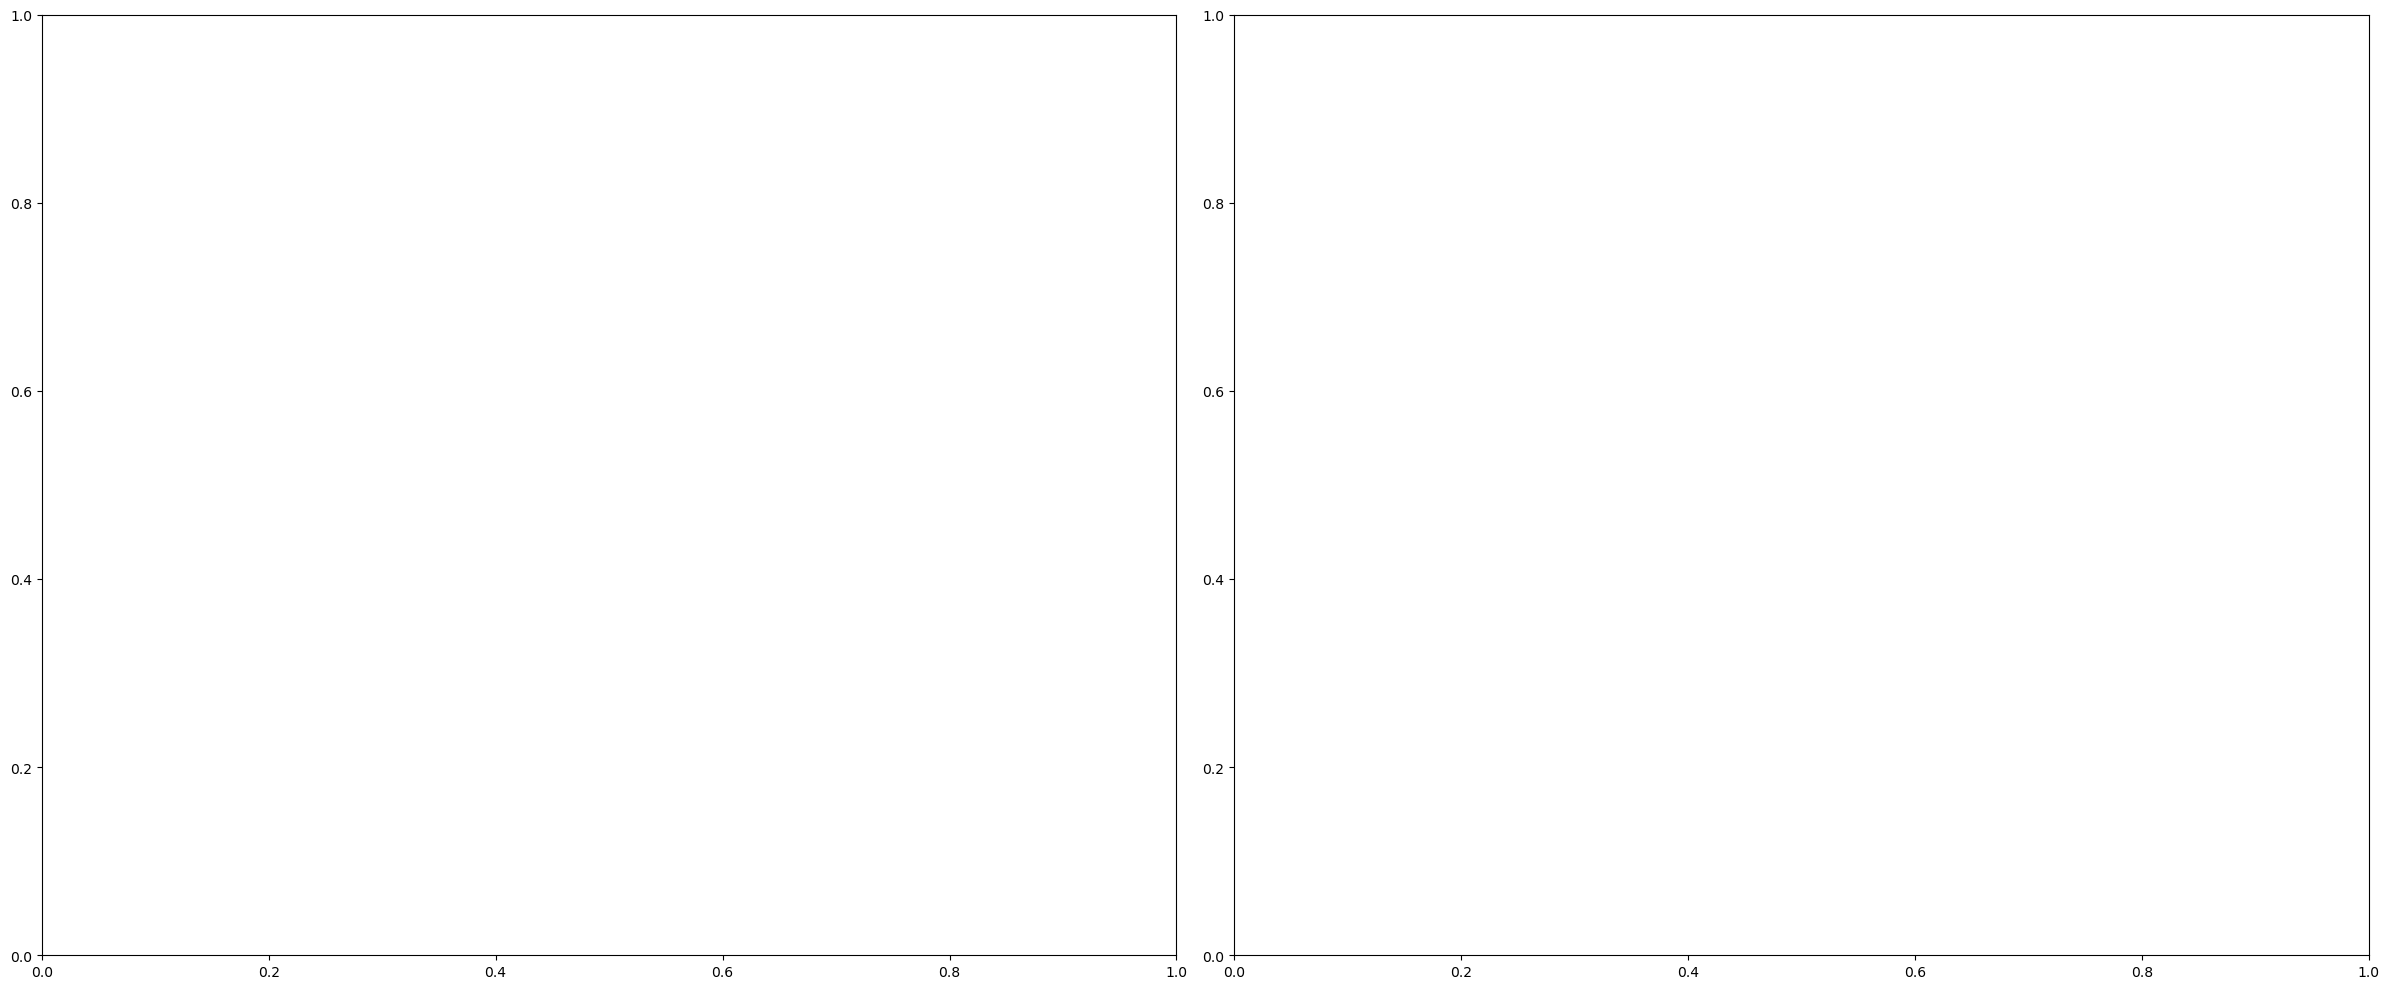

In [120]:
# 모델의 피처 중요도 시각화
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
best_xgb = print_best_params(xgb_reg, xgb_params)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

4. 회귀 모델의 예측 결과 혼합을 통한 최종 예측

In [122]:
# 각 모델의 예측갓 계산후 개별 모델과 최종 혼합 모델의 RMSE
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.1000607551761522
Ridge 모델의 RMSE: 0.10340697165289371
Lasso 모델의 RMSE: 0.10024171179335356


In [124]:
#XGBoost와 LightGBM을 혼합
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
  
get_rmse_pred(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 172
[LightGBM] [Info] Start training from score 12.025343
최종 혼합 모델의 RMSE: 0.10309935843204109
XGBM 모델의 RMSE: 0.10881175300528614
LGBM 모델의 RMSE: 0.10363891833477148


5.스태킹 앙상블 모델을 통한 회귀 예측

In [127]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__,'모델 시작')
    
    for folder_counter,(train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트 :',folder_counter,'시작')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
       
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
   
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.